In [1]:
import torch
import data
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load doc into memory
def load_doc(filename):
    file = open(filename, 'r', encoding='utf-8-sig')
    text = file.read()
    file.close()
    return text

In [4]:
def getDataDir(model):
    # returns data directory for the model
    if model == 'cda.pt':
        return '/home/urwa/Documents/Courses/NLU/GBLM/GBLM/Pytorch Model/CDA/wikitextCDA'
    else:
        return './data/wikitext-2'

In [5]:
cuda = True
seed = 20190328
#dataDir = './data/wikitext-2'
#words = 10000
#temperature = 1.0
#log_interval = 500

In [6]:
# Set the random seed manually for reproducibility.
torch.manual_seed(seed)
if torch.cuda.is_available():
    if not cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")

device = torch.device("cuda" if cuda else "cpu")

In [7]:
def getIdx(sentence):
    tok = sentence.split()
    idx = torch.LongTensor([[corpus.dictionary.word2idx[t] for t in tok]]).t().to(device)
    return idx

In [8]:
femaleFile = '/home/urwa/Documents/Courses/NLU/GBLM/GBLM/Loss Function/gender_words/female_word_file.txt'
maleFile = '/home/urwa/Documents/Courses/NLU/GBLM/GBLM/Loss Function/gender_words/male_word_file.txt'

def getGenderIdx(femaleFile, maleFile, word2idx):
    female_word_list = load_doc(femaleFile).split('\n')
    male_word_list = load_doc(maleFile).split('\n')
    #print(len(female_word_list),len(male_word_list))
    pairs = [ (word2idx[f],word2idx[m]) for f,m in zip(female_word_list,male_word_list) \
             if f in word2idx and m in word2idx]
    femaleIdx = [ f for f,m in pairs]
    maleIdx = [ m for f,m in pairs]
    print('gender pairs: ',len(femaleIdx))
    return femaleIdx,maleIdx

In [9]:
def logRatioLossFast(output, f_onehot, m_onehot):
        flato = output.view(-1, ntokens)
        m1 = torch.matmul(m_onehot,flato.t())
        m2 = torch.matmul(f_onehot,flato.t())
        avg_loss = torch.mean(torch.log((torch.exp(m1) + 0.00001) / (torch.exp(m2) + 0.00001)))
        abs_loss = torch.mean(torch.abs(torch.log((torch.exp(m1) + 0.00001) / (torch.exp(m2) + 0.00001))))
        return abs_loss.item(), avg_loss.item()

In [10]:
def getBias(model,idx):

    hidden = model.init_hidden(1)
    output, hidden = model(idx, hidden)
    dist = output[idx.shape[0]-1][0]
    
    absbias,avgbias = logRatioLossFast(output, f_onehot, m_onehot)
    return absbias,avgbias

In [11]:
def getUpper(word):
    #print(word)
    word = word[0].upper() + word[1:]
    return word

In [12]:
Occupations = load_doc('neutralOccupations.txt').split('\n')
Occupations += [getUpper(w) for w in Occupations if len(w)>0]
len(Occupations)

81

In [13]:
def getSentence(template):
    labels = []
    sentences = []
    for i in range(len(occupations)):
        s = occupations[i]+template
        labels.append(occupations[i])
        sentences.append(s)
    for i in range(len(occupations)):
        s = 'The ' + occupations[i]+template
        labels.append(occupations[i])
        sentences.append(s)   
    return sentences, labels

In [14]:
def getTotBias(checkpoint):
    with open(checkpoint, 'rb') as f:
        model = torch.load(f).to(device)
    model.eval()
    absbiasList = []
    avgbiasList = []
    for s in sentences:
        idx = getIdx(s)
        absbias,avgbias = getBias(model,idx)
        absbiasList.append(absbias)
        avgbiasList.append(avgbias)
    return absbiasList,avgbiasList 

In [15]:
templates = [' is a', ' was a']

In [16]:
modelDir = './models/'
modelFiles = [m for m in os.listdir(modelDir) if m.endswith('.pt')]
modelFiles

['lambda_0.1.pt',
 'lambda_0.5.pt',
 'lambda_0.8.pt',
 'lambda_1.pt',
 'cda.pt',
 'lambda_5.pt',
 'lambda_10.pt',
 'lambda_0.01.pt',
 'lambda_0.pt',
 'lambda_2.pt']

In [20]:
biasList = []
biasDist = []
for m in modelFiles:
    print('processing: ',m)
    
    dataDir = getDataDir(m)
    corpus = data.Corpus(dataDir)
    ntokens = len(corpus.dictionary)
    
    femaleIdx,maleIdx = getGenderIdx(femaleFile, maleFile, corpus.dictionary.word2idx)

    f_onehot = np.zeros((len(femaleIdx), ntokens))
    f_onehot[np.arange(len(femaleIdx)), femaleIdx] = 1
    f_onehot = torch.tensor(f_onehot, dtype = torch.float).to(device)

    m_onehot = np.zeros((len(femaleIdx), ntokens))
    m_onehot[np.arange(len(femaleIdx)), maleIdx] = 1
    m_onehot = torch.tensor(m_onehot, dtype = torch.float).to(device)
    
    occupations = [o for o in Occupations if o in corpus.dictionary.word2idx]
    print('occupations: ',len(occupations))
    
    # depends on getSentence function
    templateLabels = []
    sentences = []
    for t in templates:
        sent,label = getSentence(t)
        sentences += sent
        templateLabels += label
    print('templates: ',len(sentences))
    
    checkpoint = modelDir+m
    absbiasList,avgbiasList = getTotBias(checkpoint)
    biasList.append( (sum(absbiasList)/len(absbiasList),sum(avgbiasList)/len(avgbiasList)) )
    biasDist.append(list(zip(templateLabels,avgbiasList)))
    print(  (sum(absbiasList)/len(absbiasList),sum(avgbiasList)/len(avgbiasList))  )

processing:  lambda_0.1.pt
gender pairs:  58
occupations:  39
templates:  156
(0.009194122969160955, 0.005067436088154045)
processing:  lambda_0.5.pt
gender pairs:  58
occupations:  39
templates:  156
(0.0017517376094101332, -0.0002122788515780718)
processing:  lambda_0.8.pt
gender pairs:  58
occupations:  39
templates:  156
(0.009641169519641269, 0.001134116618756637)
processing:  lambda_1.pt
gender pairs:  58
occupations:  39
templates:  156
(0.0007921423705575319, -6.378029462585124e-05)
processing:  cda.pt
gender pairs:  133
occupations:  39
templates:  156
(0.31267510927640474, -0.09701955867692447)
processing:  lambda_5.pt
gender pairs:  58
occupations:  39
templates:  156
(0.00038902061369765597, 4.407183900977357e-05)
processing:  lambda_10.pt
gender pairs:  58
occupations:  39
templates:  156
(0.0005582006870565984, 1.5708960706188707e-05)
processing:  lambda_0.01.pt
gender pairs:  58
occupations:  39
templates:  156
(0.048960783160649814, 0.02750317686691116)
processing:  lam

In [21]:
biasMod = [b[0] for b in biasList]
biasAvg = [b[1] for b in biasList]

In [22]:
modelNames = ['.'.join(m.split('.')[:-1]) for m in modelFiles]
modelNames

['lambda_0.1',
 'lambda_0.5',
 'lambda_0.8',
 'lambda_1',
 'cda',
 'lambda_5',
 'lambda_10',
 'lambda_0.01',
 'lambda_0',
 'lambda_2']

In [23]:
## Just arranging model names by lambda
mm = ['lambda_0','cda', 'lambda_0.01','lambda_0.1', 'lambda_0.5', 'lambda_0.8',\
      'lambda_1', 'lambda_2', 'lambda_5','lambda_10']
biasMod = [dict(zip(modelNames,biasMod))[m] for m in mm]
biasAvg = [dict(zip(modelNames,biasAvg))[m] for m in mm]
biasDist = [dict(zip(modelNames,biasDist))[m] for m in mm]
modelsNames = mm

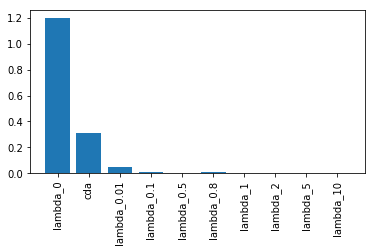

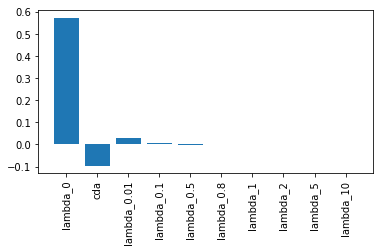

In [24]:
plt.figure(figsize=(6,3))
plt.bar(modelsNames, biasMod)
_=plt.xticks(modelsNames, rotation='vertical')

plt.figure(figsize=(6,3))
plt.bar(modelsNames, biasAvg)
_=plt.xticks(modelsNames, rotation='vertical')

In [109]:
biasDict = []
for i in range(len(modelsNames)):
    bDist = biasDist[i]
    bdict = {}
    countDict = {}
    for b in bDist:
        if b[0] in bdict:
            countDict[b[0]] += 1
            bdict[b[0]] += b[1]
        else:
            bdict[b[0]] = b[1]
            countDict[b[0]] = 1
    
    for b in bdict:
        bdict[b] /= countDict[b]
    biasDict.append(bdict)

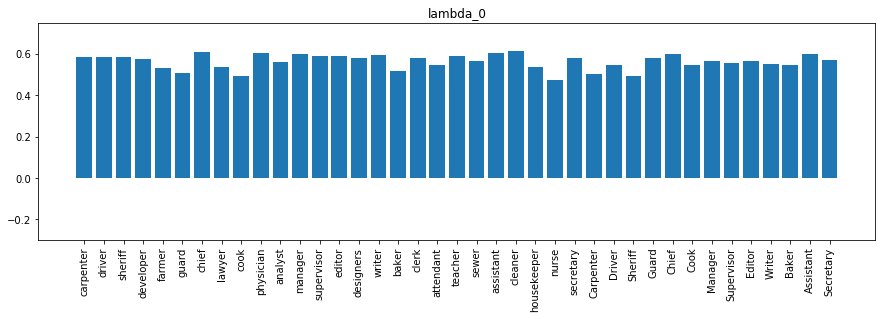

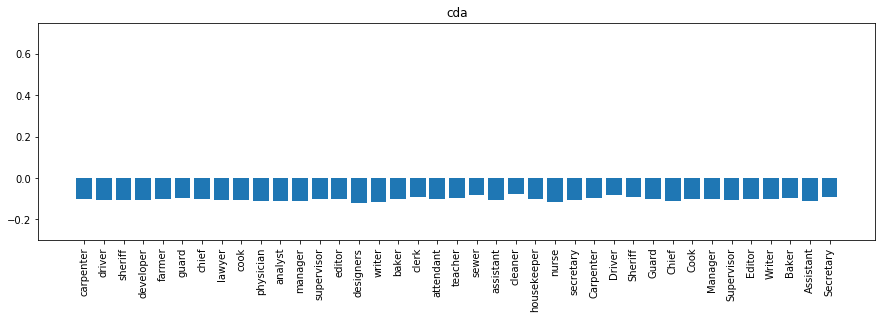

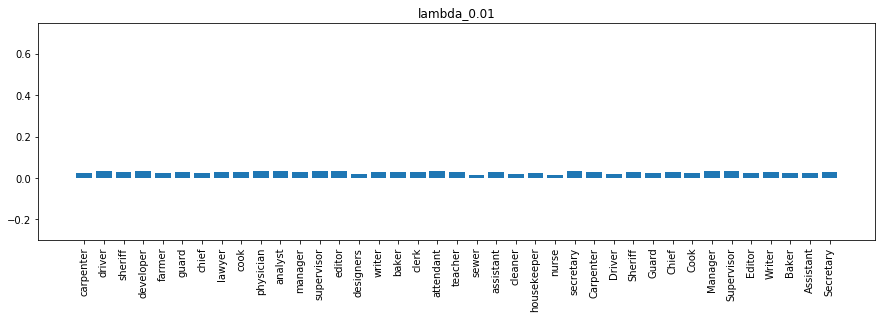

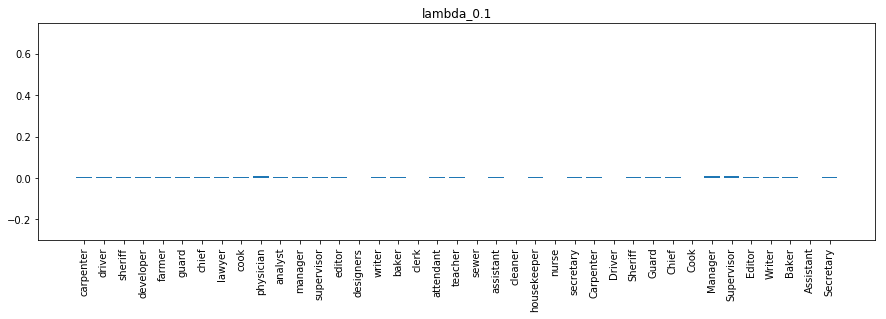

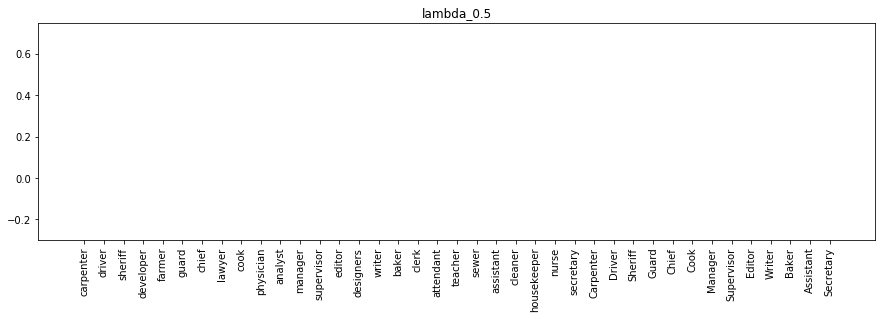

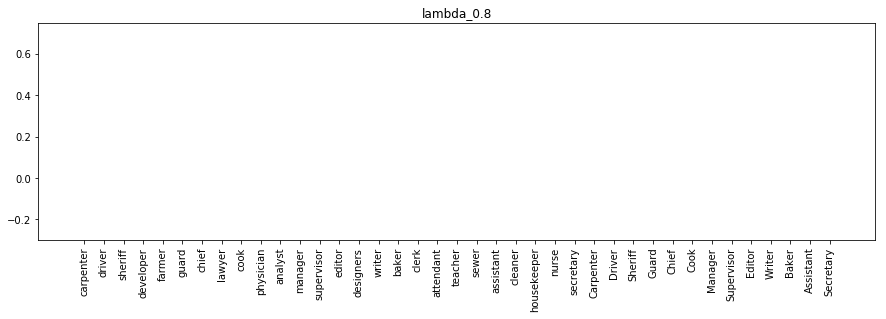

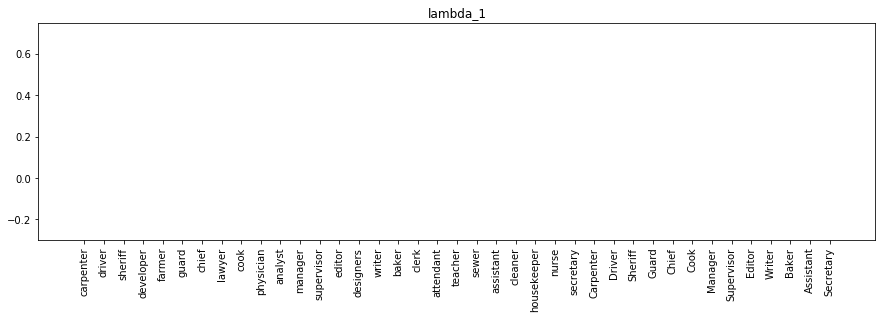

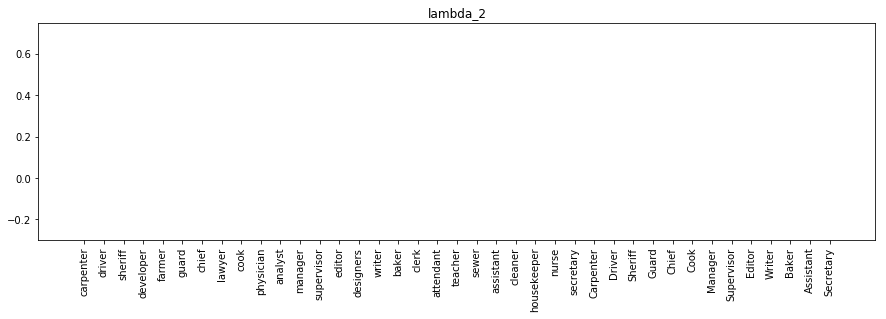

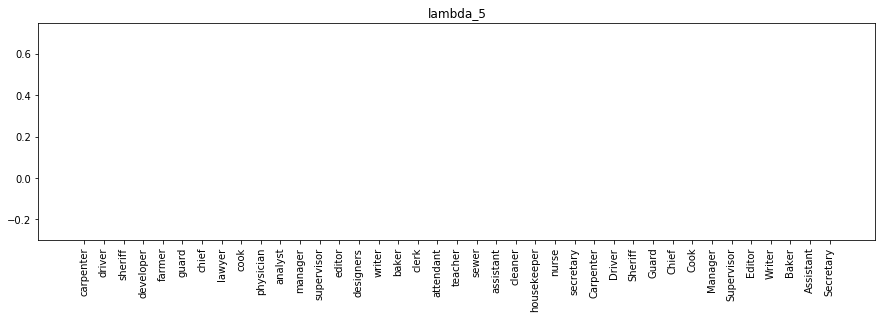

In [113]:
#biasDist
for i in range(len(modelsNames)):
    bdict = biasDict[i]
    plt.figure(figsize=(15,4))
    plt.bar(list(bdict.keys()), list(bdict.values()))
    plt.title(modelsNames[i])
    plt.ylim((-0.3,0.75))
    _=plt.xticks(list(bdict.keys()), rotation='vertical')